# Neural Fitted Q (NFQ)

In reinforcement learning, we build agents that are capable of learning from feedback that is simultaneously **evaluative, delayed, and sampled**. 

**Delayed feedback**. Imagine a chess game in which you make a few wrong moves early on, but the consequences only manifest at the end of the game. Delayed feedback makes it tricky to interpret the source of the feedback and rise the **temporal credit assignment problem**: the challenge of determining which state, action, or state-action pair is responsible for a reward. The opposite is **immediate feedback**. In supervised learning decisions don’t have long-term consequences. For example, in a classification problem, classifying an image, whether correctly or not, has no bearing on future performance.

<img src="./images/sequential-feedback.png" width="550">

**Evaluative feedback**: the goodness of the feedback is only relative, because the environment is uncertain. The agent doesn’t know the actual dynamics of the environment (no access to the transition and reward functions). As a result, the agent must explore the environment, but the  problem is that by exploring the agent misses capitalizing on its current knowledge. This is the exploration-exploitation trade-off. The opposite is **supervised feedback**. In a classification problem, during learning, the model is given the correct labels for each of the samples provided: there’s no guessing. 

<img src="./images/evaluative-feedback.png" width="600">

**Sampled feedback**: in real problems, agents are unlikely to sample all possible feedback exhaustively. Agents **need to generalize** using the gathered feedback and come up with intelligent decisions based on that generalization. The opposite is **exhaustive feedback**, where agents have access to all possible samples. Tabular reinforcement learning only needs to sample for long enough to gather all necessary information for optimal performance and they have optimal convergence guarantees. Common assumptions, such as "sampling every state-action pair infinitely often", are reasonable assumptions in small grid worlds with finite state and action spaces, but not in real settings.

<img src="./images/sampled-feedback.png" width="600">

If the feedback is evaluative, delayed and sampled at the same time, the challenge is even more significant. Algorithms must simultaneously balance immediate and long-term goals, the gathering and utilization of information and the need of generalization.

The main drawback of **tabular reinforcement learning** (the methods that we have seen so far) is that the use of a table to represent value functions is **no longer practical in complex problems**. For example, Q-learning estimates the values of the optimal action-value function Q, which is represented by a matrix indexed by states and actions:

<img src="./images/tabular-rl.png" width="600">

In many of the tasks to which we would like to apply reinforcement learning **the state space is combinatorial and enormous**. Environments can have **high-dimensional state spaces** (the number of variables that comprise a single state is vast) or can additionally have **continuous variables** (a single variable can take on an infinite number of values). How do we make a table that takes all these values into account? We can discretize the state space, but they can still take on a large number of values to make it impractical for learning without **function approximation**. Tabular solutions are **impractical** for the size of matrices. Moreover, we cannot expect to find an optimal policy, our goal instead is to find a **good approximate solution** using limited computational resources. 

The problem with large state spaces is not just the memory needed for large tables, but **the time needed to fill them accurately**. In many of our target tasks, **almost every state encountered will never have been seen before** and to make sensible decisions it is necessary **to generalize** from previous encounters with different states that are **in some sense similar** to the current one. 

How can experience with a limited subset of the state space be usefully generalized to produce a good approximation over a much larger subset? Tabular solutions are **inefficient** for the **lack of generalization**, that can discover underlying relationships. 

Generalization from examples has already been extensively studied, and we do not need to invent totally new methods for use in reinforcement learning. To some extent we need only **combine reinforcement learning methods with existing generalization methods**. The kind of generalization we require is often called **function approximation**, because it takes examples from a desired function (e.g., a value function) and attempts to generalize from them to construct an approximation of the entire function. Function approximation is an instance of **supervised learning**. In theory, any of the methods studied in this field can be used in the role of function approximator within reinforcement learning algorithms, although in practice some fit more easily into this role than others.

## The Cart-pole environment

It is a classic in reinforcement learning. The state space is low dimensional but **continuous**. Training is fast, yet still somewhat challenging, and function approximation can help. 

<img src="./images/cart-pole.png" width="500">

Its state space is comprised of four variables: 

- position on the track (x-axis) with a range from –2.4 to 2.4; 
- velocity along the track (x-axis) with a range from –inf to inf; 
- angle with a range of –40 degrees to 40 degrees; 
- velocity at the tip with a range of –inf to inf.

There are two available actions in every state: 

- action 0 applies a –1 force to the cart (push it left)
- action 1 applies a +1 force to the cart (push it right)

The cart reach a terminal state if: 

- the angle is more than 12 degrees away from the vertical position; 
- the center is more than 2.4 units from the center of the track; 
- the episode count reaches 500 time steps. 

The reward function is +1 for every time step.

In [71]:
import gymnasium
cartpole = gymnasium.make('CartPole-v1', render_mode="rgb_array")

In [72]:
print(cartpole.observation_space.shape[0])

4


We can show the environment with a random agent:

In [85]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

def show_policy(env, pi, n_episodes=1, max_steps=500):
    for _ in range(n_episodes):
        state = env.reset()[0]
        done = False
        steps = 0;
        while not done and steps < max_steps:
            if(pi is None):
                action = np.random.choice((0, 1))
            else:
                action = pi.select_action(agent.model, state)
            
            state, reward, done, _, _ = env.step(action)
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.show()
            steps += 1
            time.sleep(0.001)

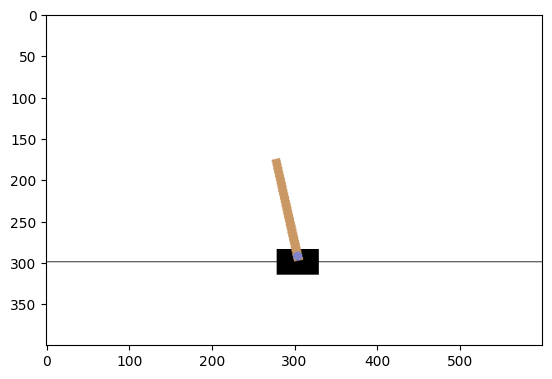

In [87]:
show_policy(cartpole, None, n_episodes=5, max_steps=500)

It in not possible to apply tabular reinforcement learning methods to this environment because the state space is continuous. We need to use function approximation in order to generalize.

## Fully Connected Q-function

The Neural Fitted Q ([M. Riedmiller, "Neural fitted Q iteration – first experiences with a data efficient neural reinforcement learning method", ECML (2005)](https://link.springer.com/chapter/10.1007/11564096_32)) is one of the first algorithms to successfully **use neural networks as a function approximation** to solve reinforcement learning problems. We refer to the approximate action-value function estimate as $Q(s,a; \theta)$, which means the $Q$ estimate is parameterized by $\theta$, the weights of a neural network, a state $s$ and an action $a$.

In order to design the function approximator, we can observe that the matrix holding the action-value function was indexed by state and action pairs, so a straightforward neural network architecture is to input the state and the action to evaluate, and output would then be one node representing the Q-value for that state-action pair:

<img src="./images/ann-nfq-1.png" width="400">

This architecture would work fine, but a more efficient architecture consists of **only inputting the state to the neural network and outputting the Q-values for all the actions**:
in that state.

<img src="./images/ann-nfq-2.png" width="450">

This is clearly advantageous when using exploration strategies such as epsilon-greedy or softmax, because **having to do only one pass forward to get the values of all actions** for any given state yields a high-performance implementation.

<img src="./images/nfq-agent.png" width="450">

We can implent this function approximator as a **Fully Connected Q-function (FCQ)** network in Python using PyTorch library:

In [42]:
import torch.nn as nn
import torch.nn.functional as F

class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc
        
        # defining the input layer
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        
        # creating the hidden layers 
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
            
        # connecting the output layer    
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, state):
        # take in the raw state and convert it into a tensor
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
            
        # pass it through the input layer
        x = self.activation_fc(self.input_layer(x))
        
        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))

        # finally, for the output layer
        x = self.output_layer(x)
        
        return x
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states)
        actions = torch.from_numpy(actions)
        new_states = torch.from_numpy(new_states)
        rewards = torch.from_numpy(rewards)
        is_terminals = torch.from_numpy(is_terminals)
        return states, actions, new_states, rewards, is_terminals

## Loss function

The **loss function** is a measure of how well a neural network predictions are. In supervised learning, it’s straightforward to interpret: given a batch of predictions and their corresponding true values, the loss function computes a distance score indicating how well the network has done in this batch.

There are many different ways for calculating this distance score, one of the most common ones is MSE (**mean squared error**, or L2 loss). It is defined as the average squared difference between the "predicted" and "true" values. In our case, the "predicted values" are the values of the action-value function that come straight from the neural network. But the "true values"?

An ideal objective would be to calculate the loss with respect to the "true" (optimal) action-value function q*:

$\displaystyle L_i(\theta_i)=E_{s,a}[(q_*(s,a)-Q(s,a;\theta_i))^2] $

Obviously, we are not talking about having access to q* (otherwise, there’s no need for learning), but if we had **access to sampling of the optimal action-value function**, we could then minimize the loss between the approximate and optimal action-value functions.

Well, we don’t have sample of that optimal values (because we don’t have the optimal policy either), remember that  

$\displaystyle q_*(s,a) = \underset{\pi }{\text{max }} E_{\pi}(G_t|S_t=s, A_t=a) $

We can use the same principles learned in generalized policy iteration, in which we **alternate between policy-evaluation and policy-improvement processes** to find good policies. However, because we’re using non-linear function approximation, **convergence guarantees no longer exist**. 

In the NFQ implementation we do just that: we start with a randomly initialized action-value function (and implicit policy); then we evaluate the policy by sampling actions from it; then, we improve it with an exploration strategy (such as epsilon-greedy); and finally, keep iterating until we reach the desired performance.

So, **we use as "true values" the targets**, which depend on a prediction also coming from the network, the value of the next state, in a circular dependency:

<img src="./images/circular-dependency.png" width="600">

As you may be thinking, **this circular dependency is bad**. It’s not well behaved because it doesn’t respect several of the assumptions made in supervised learning problems.

There are different targets we can use for estimating the action-value function of a policy: Monte Carlo (MC) target, temporal-difference (TD) target, n-step target, and lambda target:

<img src="./images/targets.png" width="600">

Moreover, the TD target can be either on-policy (SARSA) or off-policy (Q-learning), depending on the way we bootstrap the target. The two main ways are to either use the action-value function of the action the agent will take at the landing state, or alternatively, to use the value of the action with the highest estimate at the next state:

$\displaystyle Q^\text{SARSA}(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha  [ R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) ]$

$\displaystyle Q^\text{Q-learning}(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [ R_{t+1} + \gamma  \underset{a}{\text{ max }} Q(S_{t+1}, a) - Q(S_t, A_t) ]$

We could use any of these targets and get solid results, however for our NFQ implementation we keep things simple and we use the off-policy TD target of the Q-learning algorithm. 

Now, we need to substitute the optimal action-value function (that we had as the ideal equation) by the Q-learning target:

$\displaystyle L_i(\theta_i)=E_{s,a} \left[ ( r + \gamma \underset{a}{\text{ max }} Q(s',a;\theta_i) - Q(s,a;\theta_i))^2 \right] $

When differentiating through this equation, it’s important to notice that the gradient doesn’t involve the target, it must only go through the predicted value (this is one common source of error). In supervised learning, we have "predicted values" (that come from the learning model) and "true values" (commonly **constants** and provided in advance). In RL, the "true values" depend on predicted values themselves: they come from the model. For instance, when we form a TD target, we use a reward (which is a constant) and the discounted value of the next state (which comes from the model). This value is also not a "true value", and it comes from the neural network, however **it should be treated as a constant**. In PyTorch, we can do this by calling the detach method. This is vital for a reliable implementation of DRL algorithms.

$\displaystyle \nabla_{\theta_i} L_i(\theta_i)=E_{s,a} \left[ ( r + \gamma \underset{a}{\text{ max }} Q(s',a;\theta_i) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right] $

## Exploration strategy

We need to **decide how to balance the exploration-exploitation trade-off**: almost any technique would work fine. To keep things simple, we’re going to use an **epsilon-greedy strategy** on our implementation. Remember that the implication of the off-policy learning is that there are two policies: a policy that generates behavior (in this case is an epsilon-greedy policy) and a policy that we’re learning about (the greedy an ultimately optimal policy). Notice that the generating behavior can be virtually anything, as long as it has broad support: **must ensure enough exploration** of all state-action pairs. In our NFQ implementation, we will use an epsilon-greedy strategy that selects an action randomly half of the time during training. However, when evaluating the agent, we will use the action greedy with respect to the learned action-value function.

We can implement it in Python:

In [90]:
class EGreedyStrategy():
    
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon

    def select_action(self, model, state):
        # pulling out the Q-values for state s
        q_values = model(state).detach()
        # make the values NumPy friendly 
        q_values = q_values.data.numpy().squeeze()

        # get a random number..
        if np.random.rand() > self.epsilon:
            # ...if greater than epsilon, act greedily
            action = np.argmax(q_values)
        else: 
            # ...otherwise, act randomly
            action = np.random.randint(len(q_values))

        self.exploratory_action_taken = (action != np.argmax(q_values))
        return action

In [91]:
class GreedyStrategy():
    
    def select_action(self, model, state):
        q_values = model(state).detach()
        q_values = q_values.data.numpy().squeeze()
        return np.argmax(q_values)

## Optimization method

Gradient Descent (GD) is a stable optimization method given a couple of assumptions: data must be **independent and identically distributed (IID)** and targets must be **stationary**. In reinforcement learning we cannot ensure any of these assumptions. So choosing a robust optimization method (Batch Gradient Descent, Mini-batch Gradient Descent, Stochastic Gradient Descent, etc..) to minimize the loss function can often make the difference between convergence and divergence.

A classic optimization method in supervised learning is **batch gradient descent**, it takes the entire dataset at once, calculates the gradient of the dataset and steps toward this gradient a little bit at a time. Then, it repeats this cycle until convergence. When we have a considerable dataset with millions of samples, batch gradient descent is too slow to be practical. Moreover, in reinforcement learning, we don’t even have a dataset in advance, so batch gradient descent isn’t a practical method for our purpose.

<img src="./images/batch-gradient-descent.png" width="500">

An optimization method capable of handling smaller batches of data is called **mini-batch gradient descent**, where we use only a fraction of the data at a time. We can control the size of the mini-batches, which allows the processing of large datasets. At one extreme, we can set the size of mini-batch to the size of the dataset (batch gradient descent), at the other extreme, we can set the size to a single sample (**stochastic gradient descent**). The larger the batch, the lower the variance the steps of the optimization method have, but learning slows down considerably:

<img src="./images/mini-batch-gradient-descent.png" width="600">

An improved algorithm is called **gradient descent with momentum**. This is a mini-batch gradient descent that updates the network’s weights in the direction of the moving average of the gradients, instead of the gradient itself.

<img src="./images/momentum.png" width="600">

Similar to momentum is **root mean square propagation (RMSprop)**, it reduces oscillations by scaling the gradient in proportion to the average magnitude of recent gradients. A final optimization method is called **adaptive moment estimation (Adam)**, a combination of RMSprop and momentum: it steps in the direction of the velocity of the gradients (as momentum), but it scales updates in proportion to the moving average of the magnitude of the gradients (as RMSprop). 

In practice, both Adam and RMSprop are sensible choices for reinforcement learning. 

## Implement the full algorithm

Now we can put things together: 

- use a fully connected neural network with states as input and actions as output; 
- use an epsilon-greedy strategy to explore the environment;
- use the off-policy TD targets to improve the action-value function
- use mean squared error (MSE) for the loss function; 
- use RMSprop as optimizer.

The full neural fitted Q-iteration (NFQ) algorithm has three main steps:

1. collect some experiences (e.g. 1024 samples)
2. calculate the off-policy TD targets
3. fit the action-value function using MSE and RMSprop
4. repeats steps 2 and 3 a number of times before going back to step 1

<img src="./images/nfq.png" width="600">

We create a class 'NFQAgent' to collect the neural network, the exploration strategy, the evaluation strategy, the optimizer and the methods to implement the three steps of the algorithm:

In [ ]:
import random 
import torch
import torch.optim as optim

class NFQ():
    def __init__(self, env, model, optimizer, train_strategy, eval_strategy,
                 seed, batch_size, epochs):
        
        # set the seed
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        
        # store the objects
        self.env = env
        self.model = model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.batch_size = batch_size
        self.epochs = epochs

We add the 'train' to the class to manage the training process:

In [120]:
def train(self, gamma, max_minutes, max_episodes, goal_reward):
    
    # timing variables
    training_start = time.time()
    last_debug_time = float('-inf')

    self.gamma = gamma

    # vector to collect the experience
    self.experiences = []

    # stats trackers 
    self.episode_timestep = []
    self.episode_reward = []
    self.episode_seconds = []
    self.evaluation_scores = []        
    self.episode_exploration = []
    
    result = np.empty((max_episodes, 4))
    result[:] = np.nan
    
    training_time = 0
    
    # train until we either reach the max minutes, the max episodes or the goal mean reward
    for episode in range(1, max_episodes + 1):
        
        # get the start time of the episode
        episode_start = time.time()

        # reset the episode trackers
        self.episode_reward.append(0.0)
        self.episode_timestep.append(0.0)
        self.episode_exploration.append(0.0)

        # reset the environment before starting the episode    
        state, is_terminal = self.env.reset()[0], False

        # interact with the environment until the episode is done
        for step in count():

            # interact with environment using the exploration policy
            state, action, reward, new_state, is_failure = self.interaction_step(state)

            # create a new experience and append it to the memory
            experience = (state, action, reward, new_state, is_failure)
            self.experiences.append(experience)
    
            # update episode trackers
            self.episode_reward[-1] += reward
            self.episode_timestep[-1] += 1
            self.episode_exploration[-1] += int(self.train_strategy.exploratory_action_taken)

            # collect experience until the batch is full     
            if len(self.experiences) >= self.batch_size:

                # load the experiences as tensors for training
                experiences = np.array(self.experiences)
                batches = [np.vstack(experience) for experience in experiences.T]
                experiences = self.model.load(batches)

                # optimize the model for a number of epochs
                for _ in range(self.epochs):
                    self.optimize_model(experiences)

                # reset the batch
                self.experiences.clear()
            
            # if the episode is over, break out of the r
            if is_failure:
                break
            
        # timing stuff
        episode_elapsed = time.time() - episode_start
        self.episode_seconds.append(episode_elapsed)
        training_time += episode_elapsed

        # evaluate the learned policy after the episode
        evaluation_score, _ = self.evaluate()
        
        # average stats over some recent episodes
        total_step = int(np.sum(self.episode_timestep))
        evaluation_score, _ = self.evaluate()
        mean_100_train_reward = np.mean(self.episode_reward[-100:])
        std_100_train_reward = np.std(self.episode_reward[-100:])
        mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
        std_100_eval_score = np.std(self.evaluation_scores[-100:])
        result[episode-1] = total_step, mean_100_train_reward, mean_100_eval_score, training_time
            
        # informative print logging     
        reached_debug_time = time.time() - last_debug_time >= 60
        if reached_debug_time or training_is_over:
            debug_message = 'episode {:04}, steps {:06}, '
            debug_message += 'avg score {:05.1f}\u00B1{:05.1f}, '
            debug_message = debug_message.format(episode-1, total_step, mean_100_train_reward, std_100_train_reward)
            print(debug_message, end='\r', flush=True)
            last_debug_time = time.time()
            
        # check max episodes, max minutes and goal achievement criteria
        total_elapsed = time.time() - training_start
        reached_max_minutes = total_elapsed >= max_minutes * 60
        reached_max_episodes = episode >= max_episodes
        reached_goal_mean_reward = mean_100_eval_score >= goal_reward
        training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
        if training_is_over:
            if reached_max_minutes: print('--> reached_max_minutes')
            if reached_max_episodes: print('--> reached_max_episodes')
            if reached_goal_mean_reward: print('--> reached_goal_mean_reward')
            break
                
    # evaluate the final policy
    final_eval_score, final_eval_std = self.evaluate(n_episodes=100)
        
    return result, final_eval_score, final_eval_std, training_time

NFQ.myMethod = train


In [113]:
def optimize_model(self, experiences):
        
    # get the batch size
    batch_size = len(experiences)
        
    # convert the experiences into separate arrays for each element
    states, actions, rewards, next_states, is_terminals = experiences
        
    # get the values of the Q-function at next state
    # remember to detach, we need to treat these values as constants 
    q_sp = self.model(next_states).detach()
        
    # get the max value of the next state
    # unsqueeze adds a dimension to the vector so the 
    # operations that follow work on the correct elements
    max_a_q_sp = q_sp.max(1)[0].unsqueeze(1)
        
    # one important step, often overlooked, is to ensure 
    # terminal states are grounded to zero
    max_a_q_sp *= (1 - is_terminals)
        
    # calculate the target 
    target_q_sa = rewards + self.gamma * max_a_q_sp
        
    # finally, we get the current estimate of Q(s,a)
    q_sa = self.model(states).gather(1, actions)

    # create the errors
    td_errors = q_sa - target_q_sa
        
    # calculate the loss, and optimize the online network
    value_loss = td_errors.pow(2).mul(0.5).mean()
    self.optimizer.zero_grad()
    value_loss.backward()
    self.optimizer.step()

NFQ.myMethod = optimize_model


In [118]:
def interaction_step(self, state):
    action = self.train_strategy.select_action(self.model, state)
        
    # collect an experience tuple as usual
    new_state, reward, is_terminal, is_truncated, info = self.env.step(action)
        
    # a failure is defined as follows
    is_failure = is_terminal and not is_truncated
        
    # add the terminal flag if the episode ended in failure
    # if it isn’t a failure, we want to bootstrap on the value of the new_state 
    return state, action, reward, new_state, float(is_failure)

NFQ.myMethod = interaction_step

In [105]:
def evaluate(self, n_episodes=1):
    rs = []
    for _ in range(n_episodes):
        s, d = self.env.reset()[0], False
        rs.append(0)
        for _ in count():
            a = self.eval_strategy.select_action(self.model, s)
            s, r, d, _, _ = self.env.step(a)
            rs[-1] += r
            if d: break
    return np.mean(rs), np.std(rs)

NFQ.myMethod = evaluate

We can apply the NFQ algorithm to the Cart-pole environment:

In [127]:
gamma = 1.00

max_minutes = 20
max_episodes = 10000
goal_reward = 475

batch_size = 1024
epochs = 40

nfq_results = []
best_agent = None
best_eval_score = float('-inf')

nS, nA = cartpole.observation_space.shape[0], cartpole.action_space.n

for seed in (12, 34, 56, 78, 90):    

    print('Training started...')
    
    model = FCQ(nS, nA, hidden_dims=(512,128))
    optimizer = optim.RMSprop(model.parameters(), lr=0.0005)
    train_strategy = EGreedyStrategy(epsilon=0.5)
    eval_strategy = GreedyStrategy()
    
    agent = NFQ(cartpole, model, optimizer, train_strategy, eval_strategy, seed, batch_size, epochs)
    result, score, score_std, training_time = agent.train(gamma, max_minutes, max_episodes, goal_reward)

    nfq_results.append(result)
    if score > best_eval_score:
        best_eval_score = score
        best_agent = agent
    
    print('...training complete.')
    print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time\n'.format(score, score_std, training_time))
        
nfq_results = np.array(nfq_results)

Training started...
episode 0000, steps 000017, avg score 017.0±000.0, 


episode 2125, steps 121664, avg score 144.1±119.2, 
--> reached_goal_mean_reward
...training complete.
Final evaluation score 834.84±425.99 in 25.87s training time

Training started...
episode 0000, steps 000012, avg score 012.0±000.0, 
episode 1997, steps 136969, avg score 153.1±119.9, 
--> reached_goal_mean_reward
...training complete.
Final evaluation score 613.37±351.27 in 29.77s training time

Training started...
episode 0000, steps 000015, avg score 015.0±000.0, 
episode 1599, steps 103701, avg score 143.7±108.0, 
--> reached_goal_mean_reward
...training complete.
Final evaluation score 573.26±300.27 in 22.26s training time

Training started...
episode 0000, steps 000010, avg score 010.0±000.0, 
episode 1810, steps 119538, avg score 144.2±115.2, 
--> reached_goal_mean_reward
...training complete.
Final evaluation score 446.57±50.41 in 25.27s training time

Training started...
episode 0000, steps 000035, avg score 035.0±000.0, 
episode 2045, steps 167195, avg score 166.6±102.3, 
-

NFQ is not a state-of-the-art solution, however in a somewhat simple environment as the cart-pole, it shows a decent performance:

In [128]:
nfq_max_steps, nfq_max_train_reward, nfq_max_eval_score, nfq_max_time = np.max(nfq_results, axis=0).T
nfq_min_steps, nfq_min_train_reward, nfq_min_eval_score, nfq_min_time = np.min(nfq_results, axis=0).T
nfq_mean_steps, nfq_mean_train_reward, nfq_mean_eval_score, nfq_mean_time = np.mean(nfq_results, axis=0).T
nfq_episodes = np.arange(len(nfq_mean_steps))

We can plot the training reward:

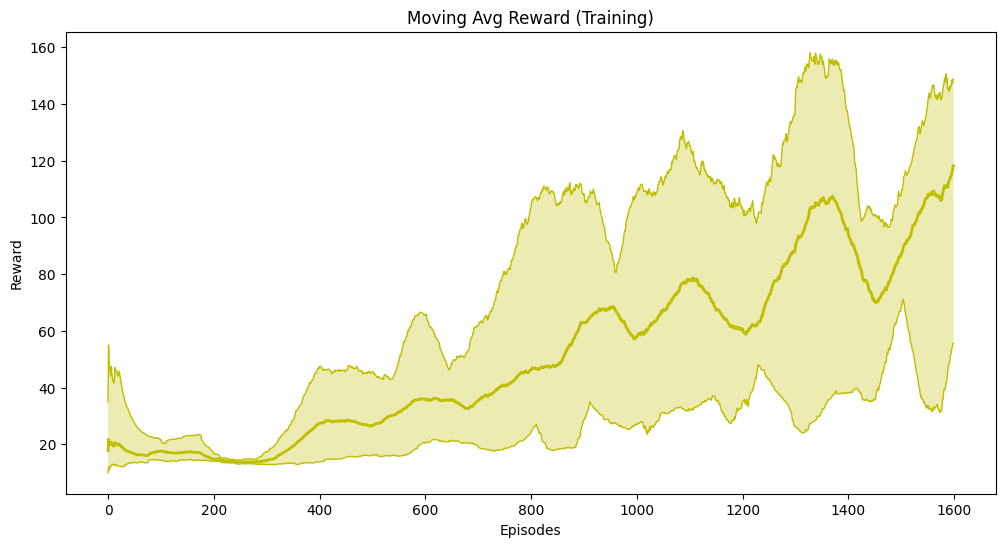

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.plot(nfq_max_train_reward, 'y', linewidth=1)
plt.plot(nfq_min_train_reward, 'y', linewidth=1)
plt.plot(nfq_mean_train_reward, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_train_reward, nfq_max_train_reward, facecolor='y', alpha=0.3)

plt.show()

It never reaches the max of 475 reward per episode. The reason is we’re using an epsilon of 0.5. Having such a high exploration rate helps with finding more accurate value functions, but it shows worse performance during training.

Plotting the reward during evaluation steps shows the best performance we can obtain from the agent:

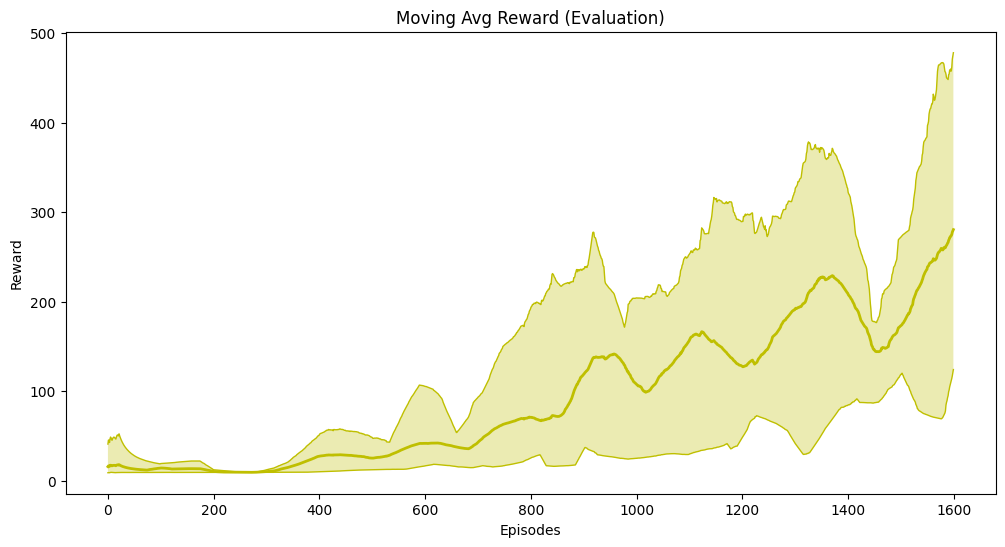

In [130]:
plt.figure(figsize=(12,6))

plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.plot(nfq_max_eval_score, 'y', linewidth=1)
plt.plot(nfq_min_eval_score, 'y', linewidth=1)
plt.plot(nfq_mean_eval_score, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_eval_score, nfq_max_eval_score, facecolor='y', alpha=0.3)

plt.show()

The main issue with NFQ is that it takes too many steps to get decent performance. In other words, in terms of sample efficiency, NFQ does poorly:

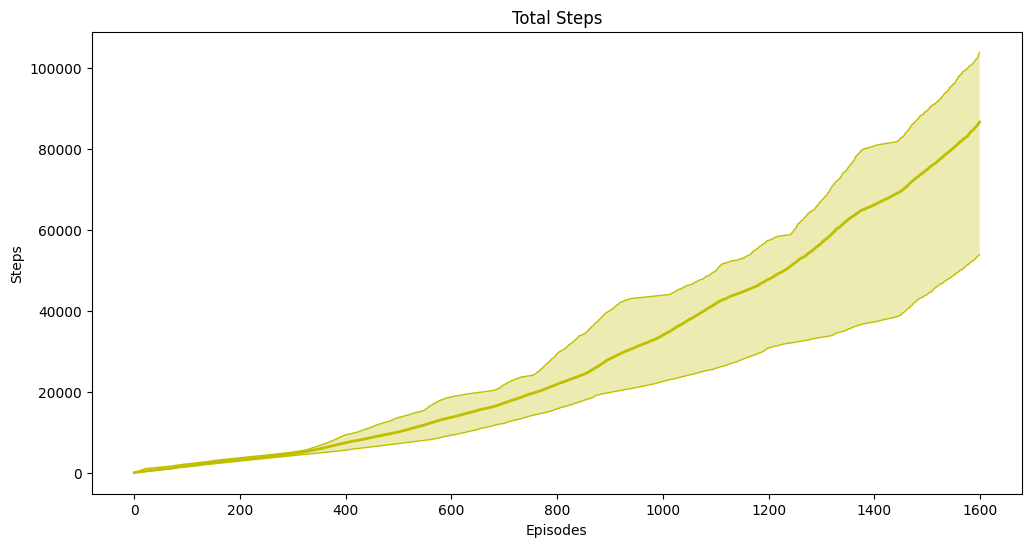

In [131]:
plt.figure(figsize=(12,6))

plt.title('Total Steps')
plt.ylabel('Steps')
plt.xlabel('Episodes')

plt.plot(nfq_max_steps, 'y', linewidth=1)
plt.plot(nfq_min_steps, 'y', linewidth=1)
plt.plot(nfq_mean_steps, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_steps, nfq_max_steps, facecolor='y', alpha=0.3)

plt.show()

We can see how NFQ takes approximately 80 seconds on average to pass the environment:

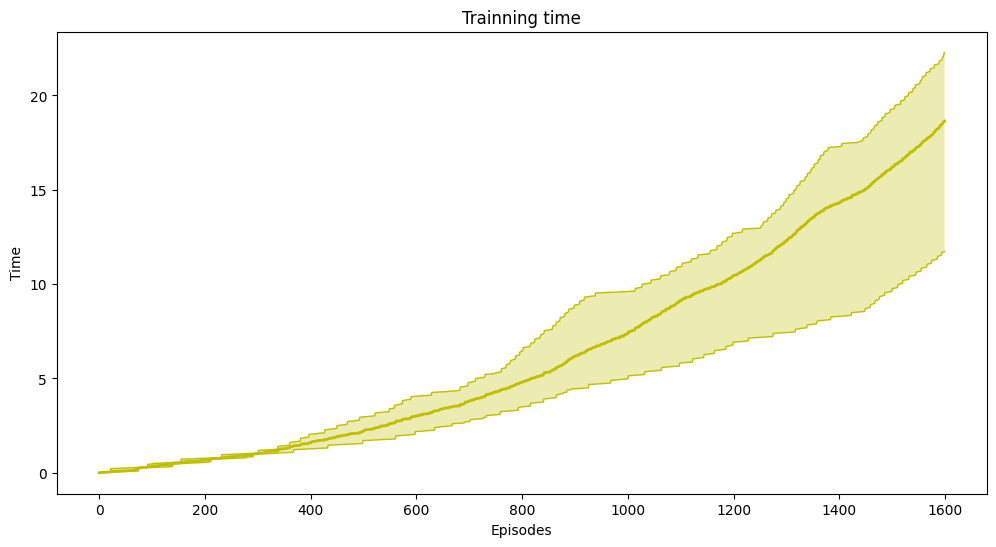

In [132]:
plt.figure(figsize=(12,6))

plt.title('Trainning time')
plt.ylabel('Time')
plt.xlabel('Episodes')

plt.plot(nfq_max_time, 'y', linewidth=1)
plt.plot(nfq_min_time, 'y', linewidth=1)
plt.plot(nfq_mean_time, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_time, nfq_max_time, facecolor='y', alpha=0.3)

plt.show()

We can display the trained model behavior:

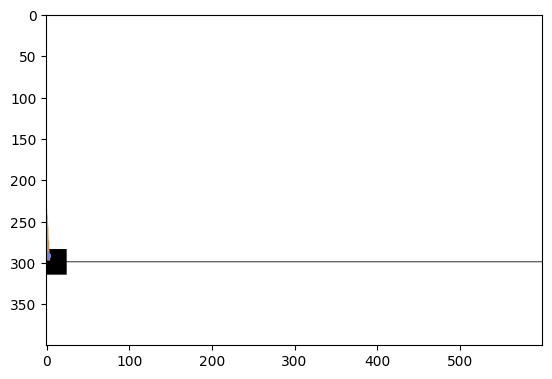

In [133]:
show_policy(cartpole, best_agent.eval_strategy, n_episodes=1, max_steps=500)

## Challenges

There are two issues with NFQ algorithm. First, we’re using a powerful function approximator, that can generalize across state-action pairs, which is excellent, but that also means that the NN adjusts the values of all similar states at once. However, notice that our target values depend on the values for the next state. In other words, we’re creating a **non-stationary target** for our learning updates. As we update the weights of the approximate Q-function, the targets also move and make our most recent update outdated. Thus, training becomes **unstable** quickly.

<img src="./images/non-stationary-target.png" width="500">

Second, we batched K experience samples, collected online, and update the NN from that mini-batch. However, these samples are **correlated**, they come from the same trajectory and policy. That means the network learns from mini-batches of samples that are similar, and later uses different mini-batches that are also internally correlated, but likely different from previous mini-batches, mainly if a different, older policy collected the samples. All this means that **we aren’t holding the IID assumption**, and this is a problem because optimization methods assume the data samples they use for training are independent and identically distributed. But we’re training on almost the exact opposite: samples are not independent (the outcome of a new state is dependent on
current state s); and, samples aren’t identically distributed (underlying data generating process, the policy, is changing over time). Optimization methods allow us to relax the IID assumption to a certain degree, but reinforcement learning problems go all the way, so we need to do something about this, too.

The way NFQ addresses these issues is through the use of **batching**. By growing a batch, we have the opportunity of optimizing several samples at the same time. The larger the batch, the more the opportunity for collecting a diverse set of experience samples. This somewhat addresses the IID assumption. 

NFQ addresses the stationarity of target requirements by using the same mini-batch in multiple sequential optimization steps. Every E episode, we "fit" the neural network to the same mini-batch K times. That K allows the optimization method to move toward the target more stably. Gathering a batch and fitting the model for multiple iterations is similar to the way we train supervised learning methods, in which we gather a dataset and train for multiple epochs.

NFQ does an okay job, but it is possible to do better. The next algorithm we will see is Deep Q-Network (DQN), which is a more stable and robust algorithm. 